#Import Library

In [1]:
pip install ccxt cryptocompare pycoingecko websockets ta nest_asyncio tensorflow scikeras catboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.0/641.0 kB 34.4 MB/s eta 0:00:00
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6291 sha256=0dd4e12afde351f3a4b772141b6d728fcd99923d75510d860b5a6a69e85c275c
  Stored in directory: /root/.cache/pip/wheels/0e/94/d6/f0f5fc4ff1b5c903ec73af2a2e9ce6d72df9d541c3b1b9db77
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a6e16cb182b5e00a3efdf2157ad3995736e49c21148f79d6dc7e28edb6a18bc9
  Stored in directory: /ro

In [2]:
pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [3]:
#Import libraries
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
from scipy.stats import pearsonr, jarque_bera
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, confusion_matrix, f1_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline as pl
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
import requests
import ccxt
from cryptocompare import get_historical_price_minute
from pycoingecko import CoinGeckoAPI
import json
from datetime import datetime, timedelta
import time
import websockets
import asyncio
import nest_asyncio
import aiohttp
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ta import add_all_ta_features  # Library khusus technical analysis
from typing import Dict, Any
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from datetime import datetime
from collections import deque
from google.colab import files, drive
import joblib
import pickle
import optuna
from optuna.samplers import TPESampler
warnings.filterwarnings("ignore")

%matplotlib inline

# Import Historical Data

In [4]:
def fetch_historical_data(symbol='BTC', currency='USD', days=365):
    # CryptoCompare (OHLCV per menit)
    cc_url = f"https://min-api.cryptocompare.com/data/v2/histominute?fsym={symbol}&tsym={currency}&limit={min(days*1440, 2000)}"
    cc_data = requests.get(cc_url).json()['Data']['Data']
    df_cc = pd.DataFrame(cc_data)
    df_cc['time'] = pd.to_datetime(df_cc['time'], unit='s', utc=True)

    # CoinGecko (Metadata)
    cg = CoinGeckoAPI()
    cg_data = cg.get_coin_market_chart_by_id(
        id='bitcoin',
        vs_currency=currency.lower(),
        days=days
    )
    df_cg = pd.DataFrame({
        'time': pd.to_datetime([x[0] for x in cg_data['prices']], unit='ms', utc=True),
        'market_cap': [x[1] for x in cg_data['market_caps']],
        'total_volume': [x[1] for x in cg_data['total_volumes']]
    })

    # Gabungkan
    return pd.merge_asof(
        df_cc.sort_values('time'),
        df_cg.sort_values('time'),
        on='time',
        direction='nearest'
    ).set_index('time').resample('1S').ffill()

btc_data = fetch_historical_data(days=30)

In [5]:
btc_data.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,market_cap,total_volume
time,,,,,,,,,,
2025-08-22 10:58:00+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,direct,,2.240519e+12,3.272568e+10
2025-08-22 10:58:01+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,direct,,2.240519e+12,3.272568e+10
2025-08-22 10:58:02+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,direct,,2.240519e+12,3.272568e+10
2025-08-22 10:58:03+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,direct,,2.240519e+12,3.272568e+10
2025-08-22 10:58:04+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,direct,,2.240519e+12,3.272568e+10


In [6]:
btcdata = btc_data.drop(['conversionType', 'conversionSymbol'], axis=1)

In [7]:
btcdata

,high,low,open,volumefrom,volumeto,close,market_cap,total_volume
time,,,,,,,,
2025-08-22 10:58:00+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:01+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:02+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:03+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:04+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
...,...,...,...,...,...,...,...,...
2025-08-23 20:17:56+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10
2025-08-23 20:17:57+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10
2025-08-23 20:17:58+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10


In [8]:
btcdata.rename(columns={'volumeto': 'volume'}, inplace=True)

In [9]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume
time,,,,,,,,
2025-08-22 10:58:00+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:01+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:02+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:03+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
2025-08-22 10:58:04+00:00,112525.33,112510.61,112510.72,5.135,577861.54,112516.03,2.240519e+12,3.272568e+10
...,...,...,...,...,...,...,...,...
2025-08-23 20:17:56+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10
2025-08-23 20:17:57+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10
2025-08-23 20:17:58+00:00,115107.53,115101.42,115107.53,1.039,119537.11,115102.27,2.291393e+12,3.019803e+10


#Feature Engineering

In [10]:
btcdata['next_price'] = btcdata['close'].shift(-1800)
btcdata = btcdata.dropna(subset=['next_price'])

In [11]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
time,,,,,,,,,
2025-08-22 10:58:00+00:00,112525.33,112510.61,112510.72,5.1350,577861.54,112516.03,2.240519e+12,3.272568e+10,112266.95
2025-08-22 10:58:01+00:00,112525.33,112510.61,112510.72,5.1350,577861.54,112516.03,2.240519e+12,3.272568e+10,112266.95
2025-08-22 10:58:02+00:00,112525.33,112510.61,112510.72,5.1350,577861.54,112516.03,2.240519e+12,3.272568e+10,112266.95
2025-08-22 10:58:03+00:00,112525.33,112510.61,112510.72,5.1350,577861.54,112516.03,2.240519e+12,3.272568e+10,112266.95
2025-08-22 10:58:04+00:00,112525.33,112510.61,112510.72,5.1350,577861.54,112516.03,2.240519e+12,3.272568e+10,112266.95
...,...,...,...,...,...,...,...,...,...
2025-08-23 19:47:56+00:00,115105.55,115087.15,115087.35,1.2730,146533.01,115103.41,2.291393e+12,3.019803e+10,115102.27
2025-08-23 19:47:57+00:00,115105.55,115087.15,115087.35,1.2730,146533.01,115103.41,2.291393e+12,3.019803e+10,115102.27
2025-08-23 19:47:58+00:00,115105.55,115087.15,115087.35,1.2730,146533.01,115103.41,2.291393e+12,3.019803e+10,115102.27


In [12]:
btcdata.columns

Index(['high', 'low', 'open', 'volumefrom', 'volume', 'close', 'market_cap',
       'total_volume', 'next_price'],
      dtype='object')

In [13]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-22 10:58:00+00:00 to 2025-08-23 19:48:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


In [14]:
btcdata.isnull().sum()

,0
high,0
low,0
open,0
volumefrom,0
volume,0
close,0
market_cap,0
total_volume,0
next_price,0


In [15]:
btcdata.shape

(118201, 9)

In [16]:
btcdata.describe()

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
count,118201.000000,118201.000000,118201.000000,118201.000000,1.182010e+05,118201.000000,1.182010e+05,1.182010e+05,118201.000000
mean,115597.469510,115548.874449,115572.751044,22.301883,2.579144e+06,115574.101520,2.300356e+12,4.609127e+10,115615.494399
std,1277.274874,1281.401307,1280.744200,65.426929,7.601808e+06,1279.004707,2.525139e+10,7.670030e+09,1217.745034
min,111738.380000,111675.140000,111690.440000,0.178000,2.060425e+04,111690.440000,2.235873e+12,3.019803e+10,111690.440000
25%,115072.820000,115053.760000,115063.700000,3.121000,3.600218e+05,115064.290000,2.290345e+12,4.146241e+10,115081.370000
50%,115733.010000,115696.800000,115715.960000,6.697000,7.728617e+05,115715.890000,2.304082e+12,5.008281e+10,115715.890000
75%,116694.900000,116641.460000,116668.530000,17.770000,2.063836e+06,116668.530000,2.321825e+12,5.171616e+10,116668.530000
max,117428.100000,117382.800000,117407.450000,1484.570000,1.737305e+08,117407.450000,2.329366e+12,5.346260e+10,117407.450000


In [17]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-22 10:58:00+00:00 to 2025-08-23 19:48:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


#Check Correlation

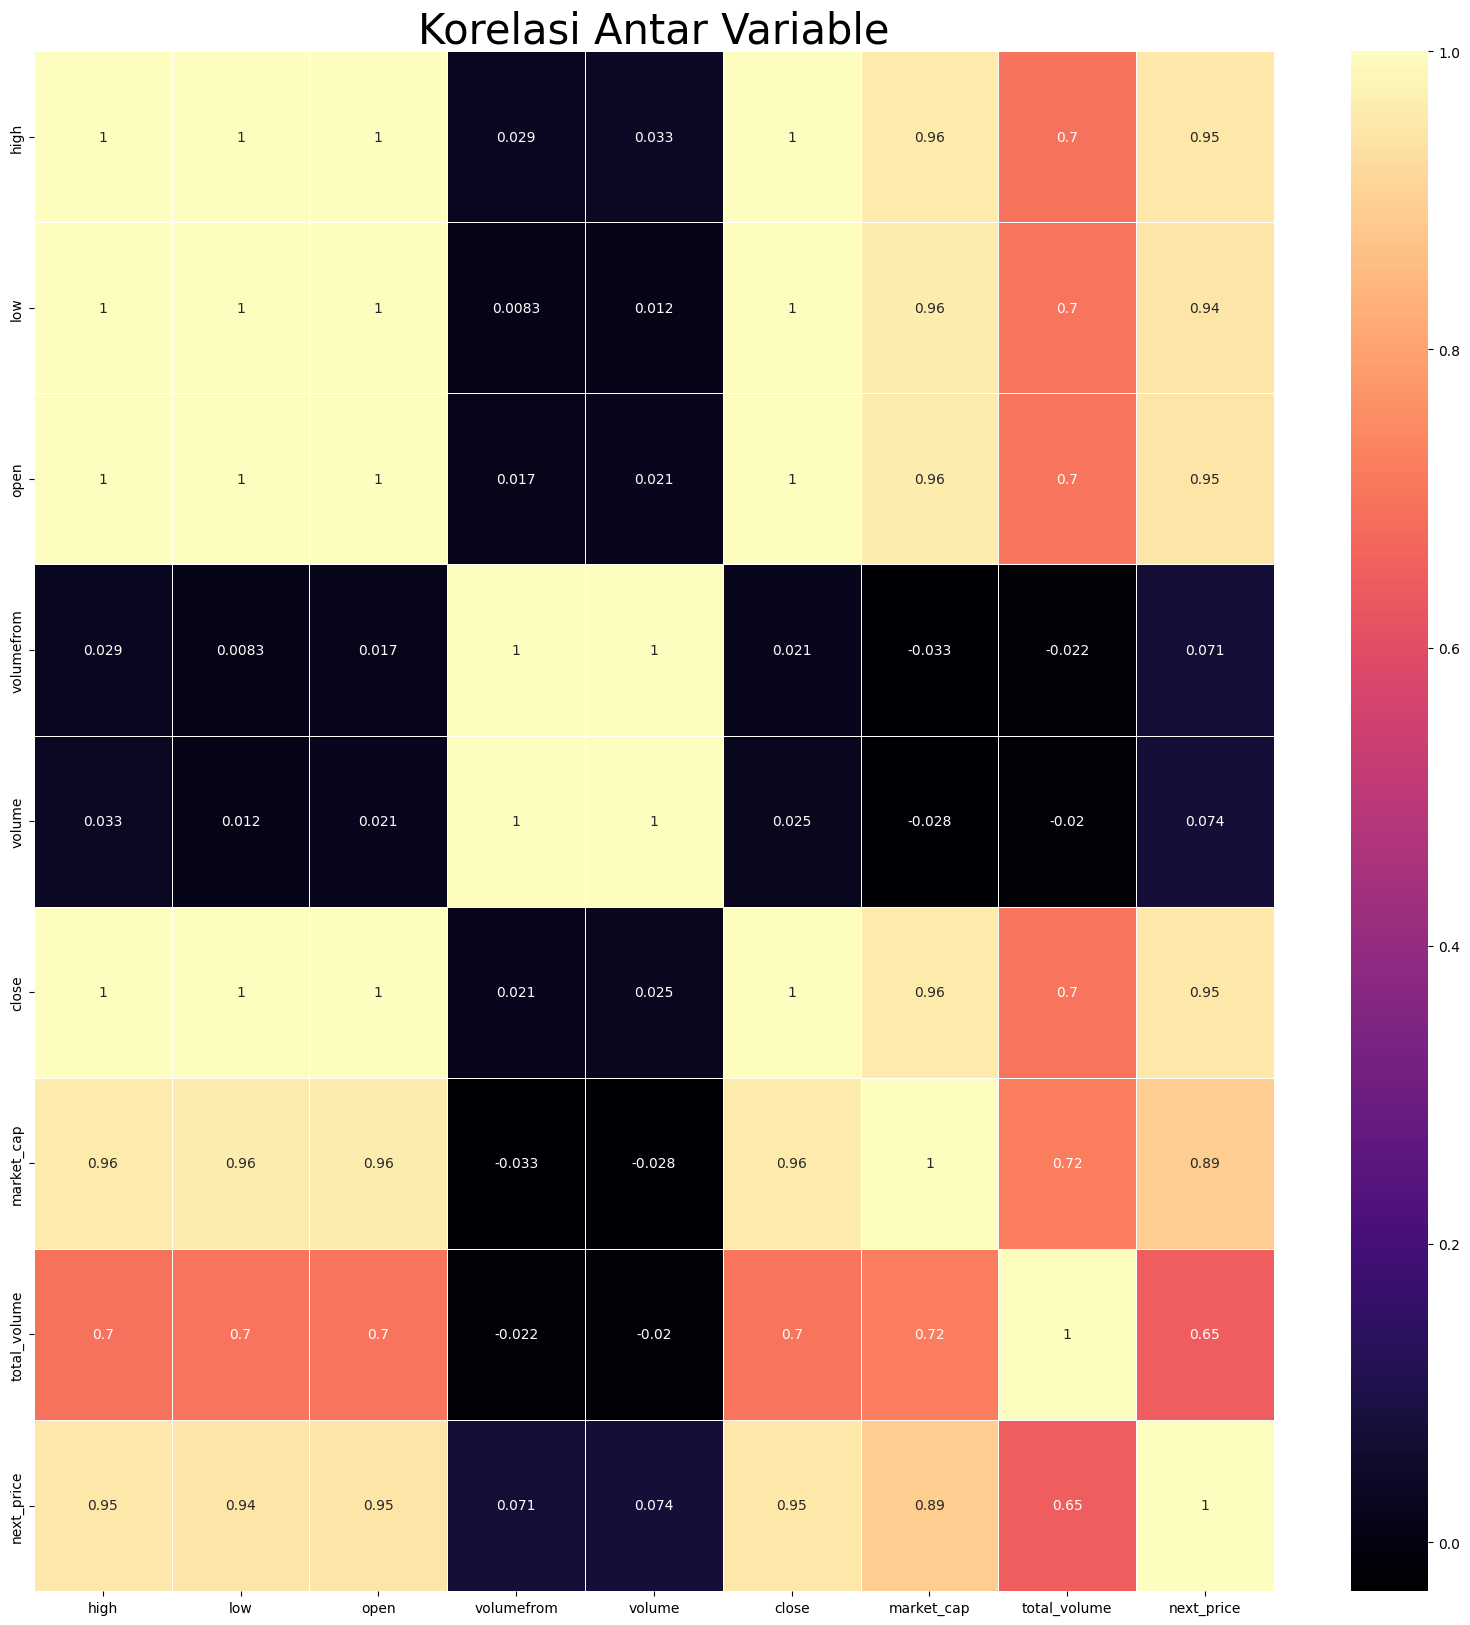

In [18]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

In [19]:
cor_matrix = btcdata.corr()
cor_matrix['next_price'].sort_values()

,next_price
volumefrom,0.071131
volume,0.074061
total_volume,0.645713
market_cap,0.892841
low,0.944103
open,0.946243
close,0.948393
high,0.950085
next_price,1.000000


In [20]:
select_columns = ['open', 'high', 'low', 'close', 'market_cap', 'next_price']
btcdata = btcdata[select_columns]

In [21]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-22 10:58:00+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:01+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:02+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:03+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:04+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
...,...,...,...,...,...,...
2025-08-23 19:47:56+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27
2025-08-23 19:47:57+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27
2025-08-23 19:47:58+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27


#Check Multicollinearity

In [22]:
def analyze_feature_correlation(df, target_col='next_5m_price', high_corr_threshold=0.9, target_corr_threshold=0.3):
    corr_matrix = df.corr()

    # 1. Korelasi antar fitur
    print("=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= high_corr_threshold and col1 != target_col and col2 != target_col:
                high_corr_pairs.append((col1, col2, corr_value))

    if high_corr_pairs:
        for col1, col2, corr_value in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"{col1} vs {col2}: corr = {corr_value:.3f}")
    else:
        print("Tidak ada korelasi tinggi antar fitur.")

    # 2. Korelasi fitur dengan target
    print("\n=== Korelasi fitur dengan target (next_3m_price) ===")
    target_corr = corr_matrix[target_col].drop(target_col)
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

    for col, val in target_corr_sorted.items():
        tag = "✅" if abs(val) >= target_corr_threshold else "⚠️"
        print(f"{tag} {col}: corr = {val:.3f}")

    # 3. Rekomendasi drop kandidat (multikolinearitas)
    print("\n=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===")
    to_drop = set()
    for col1, col2, _ in high_corr_pairs:
        # Bandingkan mana yang lebih penting dengan target
        corr1 = abs(corr_matrix[col1][target_col])
        corr2 = abs(corr_matrix[col2][target_col])
        drop = col1 if corr1 < corr2 else col2
        to_drop.add(drop)

    if to_drop:
        print("Fitur yang disarankan untuk di-drop:")
        for f in to_drop:
            print(f"❌ {f}")
    else:
        print("Tidak ada fitur yang disarankan untuk di-drop.")

    return {
        "high_corr_pairs": high_corr_pairs,
        "target_correlation": target_corr_sorted,
        "drop_recommendations": list(to_drop)
    }


In [23]:
result = analyze_feature_correlation(btcdata, target_col='next_price')

=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===
high vs close: corr = 1.000
open vs low: corr = 1.000
open vs high: corr = 0.999
low vs close: corr = 0.999
high vs low: corr = 0.999
open vs close: corr = 0.999
low vs market_cap: corr = 0.963
open vs market_cap: corr = 0.961
close vs market_cap: corr = 0.959
high vs market_cap: corr = 0.958

=== Korelasi fitur dengan target (next_3m_price) ===
✅ high: corr = 0.950
✅ close: corr = 0.948
✅ open: corr = 0.946
✅ low: corr = 0.944
✅ market_cap: corr = 0.893

=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===
Fitur yang disarankan untuk di-drop:
❌ open
❌ close
❌ market_cap
❌ low


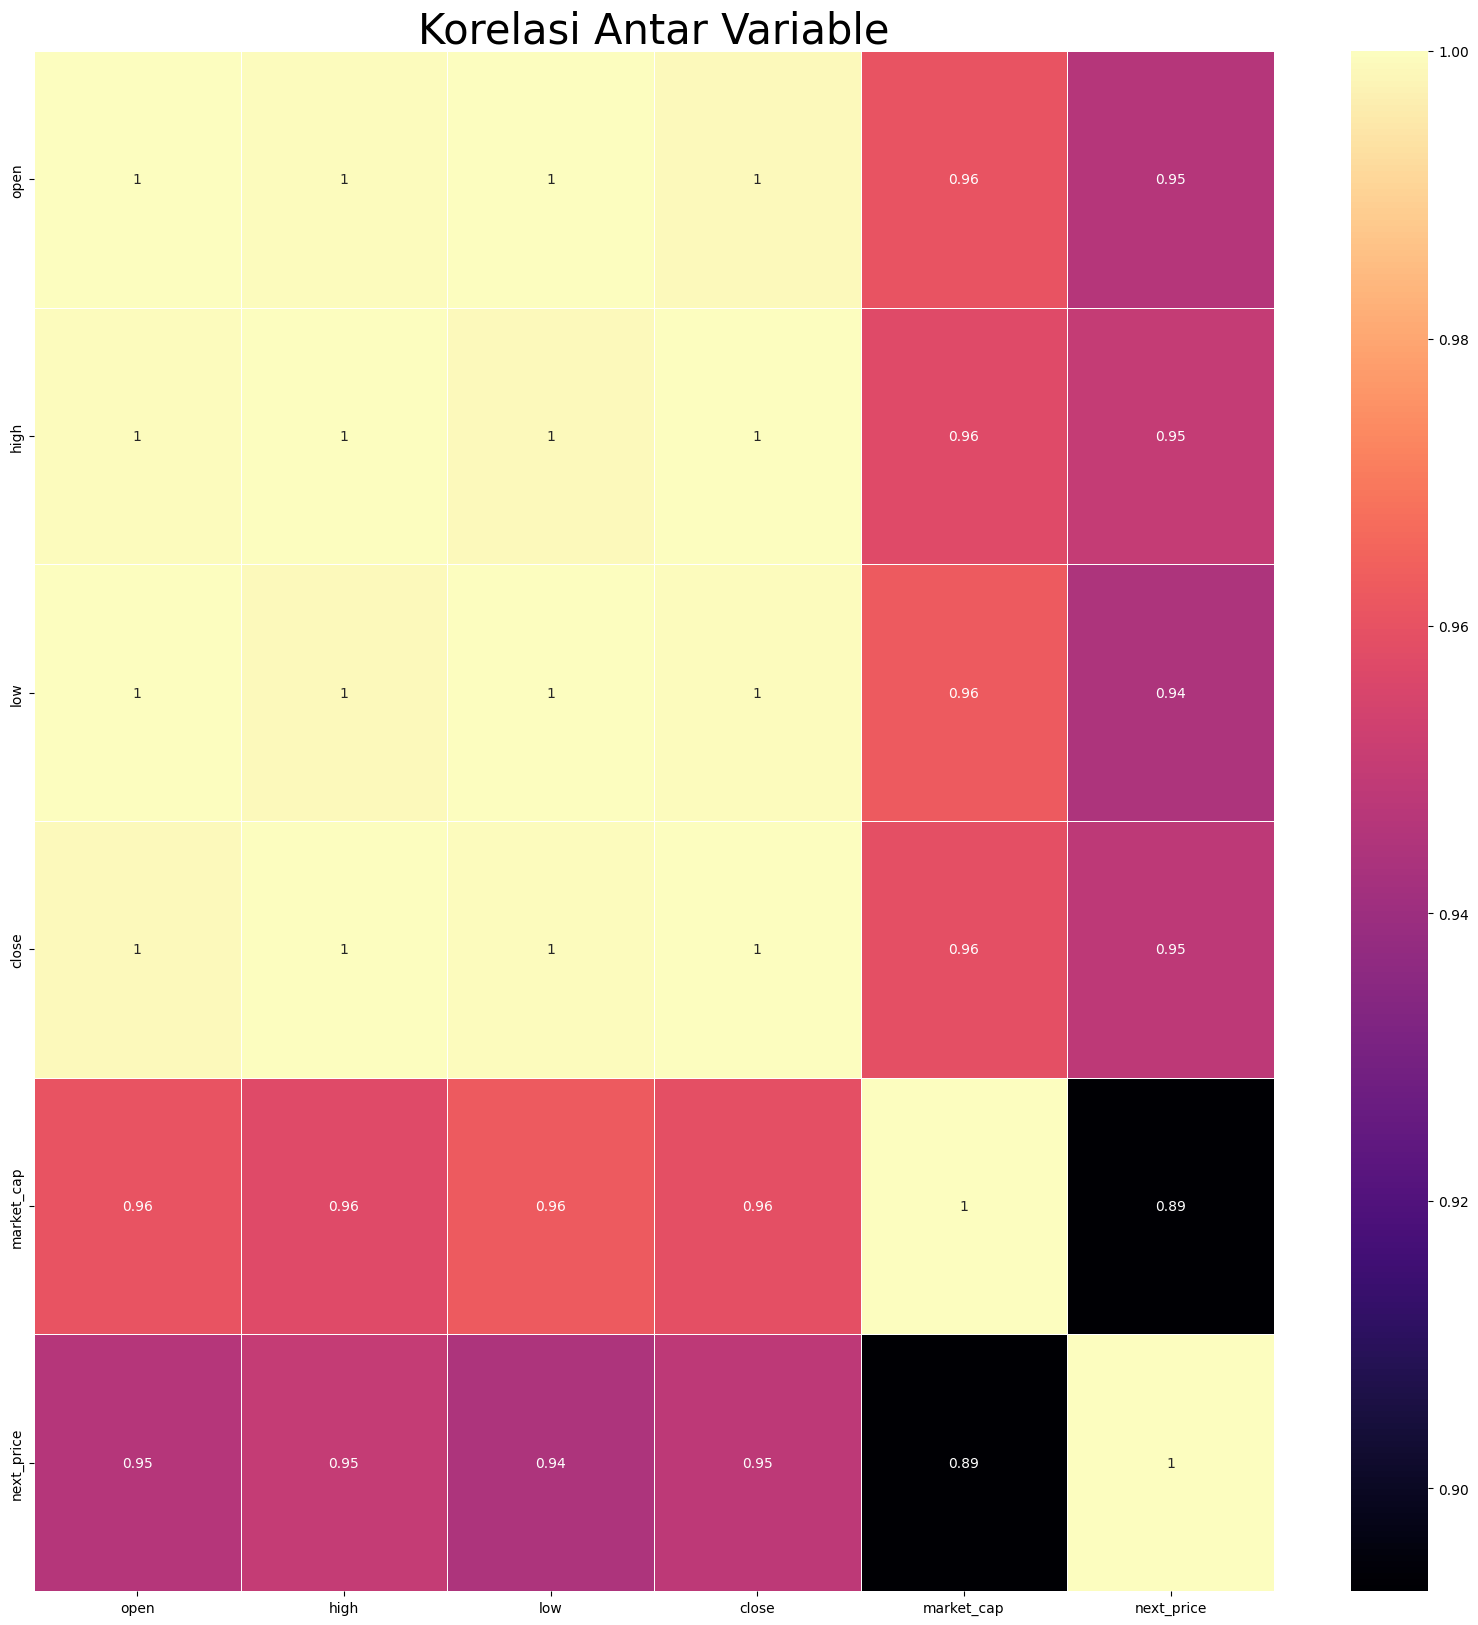

In [24]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

#LSTM

In [25]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-22 10:58:00+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:01+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:02+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:03+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
2025-08-22 10:58:04+00:00,112510.72,112525.33,112510.61,112516.03,2.240519e+12,112266.95
...,...,...,...,...,...,...
2025-08-23 19:47:56+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27
2025-08-23 19:47:57+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27
2025-08-23 19:47:58+00:00,115087.35,115105.55,115087.15,115103.41,2.291393e+12,115102.27


In [27]:
import numpy as np
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as pl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# =====================================
# 1. Custom Transformer for Scaling 3D Time Series
# =====================================
class TimeSeriesScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        self.scaler.fit(X_reshaped)
        return self

    def transform(self, X):
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        X_scaled = self.scaler.transform(X_reshaped)
        return X_scaled.reshape(n_samples, n_timesteps, n_features)

# =====================================
# 2. Function to Build the LSTM Model (Best Params)
# =====================================
SEQ_LEN = 60
def build_lstm_model(units=64, dropout_rate=0.2, optimizer='adam', lr=0.001):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    if optimizer == "adam":
        opt = Adam(learning_rate=lr)
    elif optimizer == "rmsprop":
        opt = RMSprop(learning_rate=lr)
    else:
        raise ValueError("Optimizer not recognized!")

    model.compile(optimizer=opt, loss='mse')
    return model

# =====================================
# 3. Data Preprocessing → Create Time Series Sequences
# =====================================
def create_sequences(X, y, timesteps=60):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i+timesteps)])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

# Feature and target
features = btcdata.drop(columns=['next_price'])
target = btcdata['next_price']

# Create sequences
X_seq, y_seq = create_sequences(features.values, target.values, SEQ_LEN)

# Train-test split (no shuffle)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.25, shuffle=False
)

# =====================================
# 4. Final Pipeline with Best Parameters
# =====================================
final_pipe = pl([
    ("scaler", TimeSeriesScaler()),
    ("lstm", KerasRegressor(
        model=build_lstm_model,
        units=64,                # Best param
        dropout_rate=0.2,        # Best param
        optimizer='adam',        # Best param
        lr=0.001,                # Best param
        epochs=30,               # Best param
        batch_size=32,           # Best param
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    ))
])

# Train model
final_pipe.fit(X_train_seq, y_train_seq, lstm__validation_data=(X_test_seq, y_test_seq))

# =====================================
# 5. Save Model & Parameters
# =====================================
with open("lstm_crypto_pipeline.pkl", "wb") as f:
    pickle.dump(final_pipe, f)

best_params = {
    'units': 64,
    'dropout_rate': 0.2,
    'optimizer': 'adam',
    'lr': 0.001,
    'epochs': 30,
    'batch_size': 32
}

with open("lstm_best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

print("Final LSTM pipeline and parameters saved successfully.")


Epoch 1/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 191s 66ms/step - loss: 13402801152.0000 - val_loss: 13180606464.0000
Epoch 2/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 172s 62ms/step - loss: 13361598464.0000 - val_loss: 13139461120.0000
Epoch 3/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 196s 60ms/step - loss: 13320168448.0000 - val_loss: 13098402816.0000
Epoch 4/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 166s 60ms/step - loss: 13279371264.0000 - val_loss: 13057421312.0000
Epoch 5/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 207s 62ms/step - loss: 13237567488.0000 - val_loss: 13016523776.0000
Epoch 6/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 169s 61ms/step - loss: 13195548672.0000 - val_loss: 12975668224.0000
Epoch 7/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 202s 61ms/step - loss: 13155313664.0000 - val_loss: 12934876160.0000
Epoch 8/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 197s 59ms/step - loss: 13114866688.0000 - val_loss: 12894140416.0000
Epoch 9/30
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 170s 61ms/step - loss: 13073368064.0000 - val_loss: 12853497856.0000
E

In [30]:
files.download("lstm_crypto_pipeline.pkl")
files.download("lstm_best_params.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>